In [12]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, z_dim=None):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))

    if z_dim is not None:
      self.z_layer = nn.Linear(z_dim, embed_dim)
    else:
      self.z_layer = None
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t, z=None):
    # Obtain the Gaussian random feature embedding for t
    if z is not None and self.z_layer is not None:
      z_embed = self.z_layer(z)
    embed = self.act(self.embed(t)+z_embed)
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [13]:
#@title Set up the SDE
import functools
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

def jpeg_compress(x, quality=10):
    x_int = torch.tensor((x * 255), dtype=torch.uint8).cpu()
    x_jpeg = x_int.clone()

    for i in range(x_jpeg.shape[0]):
        x_jpeg[i] = torchvision.io.decode_jpeg(torchvision.io.encode_jpeg(x_int[i].cpu(), quality=quality))

    return (x_jpeg/255).to(x.dtype)

In [14]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, x_con, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]

  score = model(perturbed_x, random_t, x_con.reshape(x_con.shape[0], -1))
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [15]:
#@title Training (double click to expand or collapse)

import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn, z_dim=784))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  64 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

dataset = MNIST('../data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [16]:
optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    x_jpeg = jpeg_compress(x, quality=10)
    loss = loss_fn(score_model, x, x_jpeg, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


In [32]:
_, (x, y) = next(enumerate(data_loader))
x = x.to(device)

x_jpeg = jpeg_compress(x, quality=1)

/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [45]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid
from models.samplers import *

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

select_t = 0.3 #@param {'type':'number'}
x_ = forward_process(x, marginal_prob_std_fn, 500, device=device, end_t=select_t, only_final=True)

/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Number of function evaluations: 134


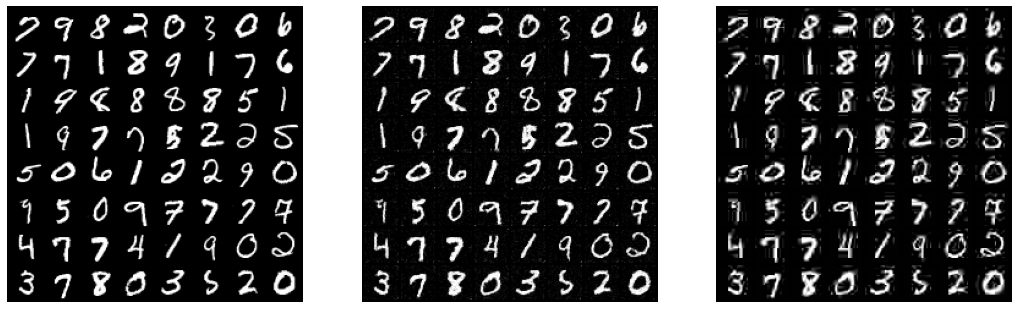

In [46]:
## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device,
                  x=x_,
                  z=x_jpeg.reshape(x_jpeg.shape[0], -1),
                  start_t=select_t,
                  )

## Sample visualization.
samples = samples.clamp(0.0, 1.0)

imgs_int = (x.clone().detach()*255).to(dtype=torch.uint8)
decoded_imgs_int = (samples.clone().detach()*255).to(dtype=torch.uint8)
imgs_jpeg_int = (x_jpeg.clone().detach()*255).to(dtype=torch.uint8)

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(decoded_imgs_int, nrow=int(np.sqrt(sample_batch_size)))
sample_ori = make_grid(imgs_int, nrow=int(np.sqrt(sample_batch_size)))
sample_jpeg = make_grid(imgs_jpeg_int, nrow=int(np.sqrt(sample_batch_size)))
fig, axs = plt.subplots(1, 3, figsize=(3 * 6, 6))
# plt.figure(figsize=(6,6))
plt.axis('off')
axs[0].imshow(sample_ori.permute(1, 2, 0).cpu(), vmin=0., vmax=255.)
axs[0].set_axis_off()
axs[1].imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=255.)
axs[1].set_axis_off()
axs[2].imshow(sample_jpeg.permute(1, 2, 0).cpu(), vmin=0., vmax=255.)
axs[2].set_axis_off()
plt.show()

In [47]:
x_int = torch.tensor((x * 255), dtype=torch.uint8).cpu()

/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [48]:
def ani_imshow(sample, sampling_number = 64):

    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255

    show_sample = show_sample.astype(np.uint8)

    return show_sample

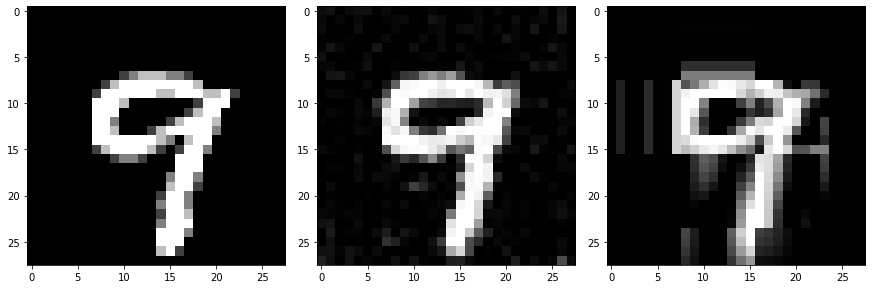

In [49]:
import matplotlib.pyplot as plt
import math

fig, axs = plt.subplots(1, 3, figsize=(4 * 3, 4), constrained_layout = True)
axs[0].imshow(ani_imshow(x[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')
axs[1].imshow(ani_imshow(samples[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')
axs[2].imshow(ani_imshow(x_jpeg[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')